# EPA1361 - Model-Based Decision Making

## Multi-model analysis

This exercise uses a simple version of the [Lotka-Volterra predator-prey equations](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations) to show how the EMA Workbench can be used for a
multi-model analysis, in addition to typical parametric/structural uncertainties. This will let you test the connectors provided in the Workbench for Excel, NetLogo, and Vensim / PySD; we'll also use the models for the sensitivity analysis exercise in week 3.

* Using the three model files provided and the Python function below, define model objects for each implementation (Excel, NetLogo, Vensim/PySD, and Python), and test them using a single ensemble. Use 50 experiments sampled from the parameters below (so that each experiment will be executed for the 4 models, for a total of 200), and retrieve outputs for the _TIME_, _predators_, and _prey_ variables.
    * excel and vensim are only supported on windows
    * vensim requires the DSS version of Vensim
    * Netlogo supoprt depends on [jpype](http://jpype.readthedocs.io/en/latest/install.html) and [pynetlogo](https://pynetlogo.readthedocs.io/en/latest/). Also, if you don't have NetLogo installed, please get it from [NetLogo 6.1.1](https://ccl.northwestern.edu/netlogo/download.shtml) 
    * for pysd, see [its documentation](http://pysd.readthedocs.io/en/master/installation.html)
    * If possible try to work with all model versions, but even 2 or 3 (pure python and something else should be sufficient).
    

|Parameter	|Range or value	        |
|-----------|--------------:|
|prey_birth_rate    	|0.015 – 0.035	|
|predation_rate|0.0005 – 0.003 	|
|predator_efficiency     	|0.001 – 0.004	    |
|predator_loss_rate	    |0.04 – 0.08	    |
|Final time	    |365	    |
|dt	    |0.25	    |

* Note that your EMA Workbench installation includes example scripts for the different connectors. The different model objects follow a similar syntax but will need to be slightly adjusted depending on the software (e.g. to specify the NetLogo run length or the sheet name in Excel). 

* These model objects can be used with a replication functionality (for instance to test the effect of stochastic uncertainty in a NetLogo model), which repeats a given experiment over multiple replications. You can use a single replication in this exercise as the models are not stochastic. By default, each outcome array will then have a shape of (# experiments, # replications, # time steps). Try adapting the outcome arrays so that they can be used with the _lines_ plotting function of the Workbench, and plot the results grouped by model.

* To check the graphical results, find the maximum absolute error of the time series you obtained for the _prey_ variable in the Excel, NetLogo, and Vensim/PySD models, relative to the Python function. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ema_workbench import (Model, RealParameter, TimeSeriesOutcome, perform_experiments,
                           ema_logging)

from ema_workbench.connectors.netlogo import NetLogoModel
from ema_workbench.connectors.excel import ExcelModel
from ema_workbench.connectors.pysd_connector import PysdModel

from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS

from ema_workbench.analysis.plotting import lines, Density


def PredPrey(prey_birth_rate=0.025, predation_rate=0.0015, predator_efficiency=0.002,
             predator_loss_rate=0.06, initial_prey=50, initial_predators=20, dt=0.25, final_time=365, reps=1):

    #Initial values
    predators, prey, sim_time = [np.zeros((reps, int(final_time/dt)+1)) for _ in range(3)]
    
    for r in range(reps):
        predators[r,0] = initial_predators
        prey[r,0] = initial_prey

        #Calculate the time series
        for t in range(0, sim_time.shape[1]-1):

            dx = (prey_birth_rate*prey[r,t]) - (predation_rate*prey[r,t]*predators[r,t])
            dy = (predator_efficiency*predators[r,t]*prey[r,t]) - (predator_loss_rate*predators[r,t])

            prey[r,t+1] = max(prey[r,t] + dx*dt, 0)
            predators[r,t+1] = max(predators[r,t] + dy*dt, 0)
            sim_time[r,t+1] = (t+1)*dt
    
    #Return outcomes
    return {'TIME':sim_time,
            'predators':predators,
            'prey':prey}

C:\Users\joren\anaconda3\envs\MBDM\lib\site-packages\ema_workbench\connectors\__init__.py:17: ImportWarning: vensim connector not available
  warnings.warn("vensim connector not available", ImportWarning)


In [2]:
from ema_workbench import Model, RealParameter, ScalarOutcome, Constant, MultiprocessingEvaluator, SequentialEvaluator

uncertainties = [RealParameter('prey_birth_rate', 0.015, 0.035),
                       RealParameter('predation_rate', 0.0005, 0.003),
                       RealParameter('predator_efficiency', 0.001, 0.004),
                      RealParameter('predator_loss_rate', 0.04, 0.08)]

constants = [Constant('Final Time', 365),
                  Constant('Time step', 0.25)]

outcomes = [TimeSeriesOutcome('prey')]

constants2 = [Constant('dt', 0.25)]

constants3 = [Constant('final_time', 365),
                  Constant('dt', 0.25)]

In [3]:
#LHS, SOBOL or MORRIS
US = LHS
processes = 10

### Py in the skie

In [4]:
import sys  
sys.path.insert(0, '../model/')
import PredPreyCode as PP

py_model = Model('Py', function=PP.PredPrey)

py_model.uncertainties = uncertainties
py_model.constants = constants3
py_model.outcomes = outcomes

In [5]:
with MultiprocessingEvaluator(py_model, n_processes=processes) as evaluator:
     results_py, outcome_py = evaluator.perform_experiments(scenarios=50, uncertainty_sampling=US)

In [6]:
print(outcome_py)

{'prey': array([[[50.        , 49.53757904, 49.06112854, ..., 19.86654342,
         19.96334382, 20.06061716]],

       [[50.        , 49.57173778, 49.14799207, ..., 88.23486937,
         87.75263573, 87.26375903]],

       [[50.        , 49.97052583, 49.94208182, ..., 64.85473233,
         64.75653651, 64.65719617]],

       ...,

       [[50.        , 49.95122378, 49.90119858, ..., 32.16481289,
         32.23324859, 32.30190829]],

       [[50.        , 49.8068707 , 49.60603199, ...,  9.19585718,
          9.15038633,  9.1061763 ]],

       [[50.        , 50.09939483, 50.19510897, ...,  7.16378078,
          7.19525326,  7.22688248]]])}


### The shape of outcomes is not correct for anything but Vensim. Below is the function that was written for this + the code on how this was discovered. Compared to the vensim outcomes that do produce a graph. It is a 3d array and should be a 2d array. 

In [7]:
print(type(outcome_py))

<class 'dict'>


In [8]:
#Get the stupid array from the stupid dict...
stupid_array = outcome_py['prey']

In [9]:
print(stupid_array)
print(type(stupid_array))
print(stupid_array.shape)

[[[50.         49.53757904 49.06112854 ... 19.86654342 19.96334382
   20.06061716]]

 [[50.         49.57173778 49.14799207 ... 88.23486937 87.75263573
   87.26375903]]

 [[50.         49.97052583 49.94208182 ... 64.85473233 64.75653651
   64.65719617]]

 ...

 [[50.         49.95122378 49.90119858 ... 32.16481289 32.23324859
   32.30190829]]

 [[50.         49.8068707  49.60603199 ...  9.19585718  9.15038633
    9.1061763 ]]

 [[50.         50.09939483 50.19510897 ...  7.16378078  7.19525326
    7.22688248]]]
<class 'numpy.ndarray'>
(50, 1, 1461)


In [10]:
#Get the inside 2d array from the 3d array
new_a = np.reshape(stupid_array, (50, 1461))
print(new_a)
print(new_a.shape)

[[50.         49.53757904 49.06112854 ... 19.86654342 19.96334382
  20.06061716]
 [50.         49.57173778 49.14799207 ... 88.23486937 87.75263573
  87.26375903]
 [50.         49.97052583 49.94208182 ... 64.85473233 64.75653651
  64.65719617]
 ...
 [50.         49.95122378 49.90119858 ... 32.16481289 32.23324859
  32.30190829]
 [50.         49.8068707  49.60603199 ...  9.19585718  9.15038633
   9.1061763 ]
 [50.         50.09939483 50.19510897 ...  7.16378078  7.19525326
   7.22688248]]
(50, 1461)


In [11]:
outcome_py = {'prey': new_a}

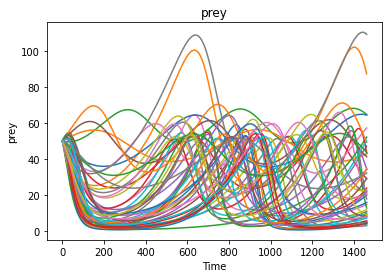

In [12]:
# :(
fig, axes = lines(results_py, outcome_py)

In [34]:
#Based on this a function to make this easier
def fix_format_pls(dictionary):
    temp_array =  dictionary['prey']
    print(temp_array.shape)
    new_a = np.reshape(temp_array, (50, 1461))
    outcome = {'prey': new_a}
    return outcome

### Vensim

In [14]:
vensim_model = PysdModel(name= "Vensim", mdl_file=r'../model/PredPrey.mdl')
vensim_model.uncertainties = uncertainties
vensim_model.constants = constants
vensim_model.outcomes = outcomes


In [15]:
with MultiprocessingEvaluator(vensim_model, n_processes=processes) as evaluator:
    vensim_results, vensim_outcomes = evaluator.perform_experiments(scenarios=50, uncertainty_sampling=US)

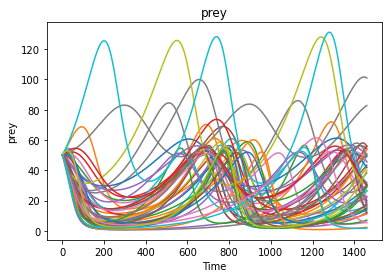

In [16]:
figure = lines(vensim_results, vensim_outcomes) #show lines, and end state density
plt.show() #show figure

In [17]:
print(vensim_outcomes)
temp = vensim_outcomes['prey']
print(temp.shape)

{'prey': array([[50.        , 50.1186975 , 50.2332161 , ..., 20.65339463,
        20.32189435, 19.99644037],
       [50.        , 49.71658973, 49.42959473, ..., 22.60380866,
        22.6817903 , 22.76007818],
       [50.        , 49.88359168, 49.75395065, ..., 26.36385027,
        26.56164916, 26.76076304],
       ...,
       [50.        , 49.72542245, 49.44495198, ..., 49.98856269,
        49.64355582, 49.29270119],
       [50.        , 50.19934263, 50.39385295, ..., 39.24457516,
        39.52237218, 39.8012268 ],
       [50.        , 49.68903661, 49.36312153, ...,  1.71420654,
         1.71633122,  1.71852604]])}
(50, 1461)


### Excel

In [30]:
excel_model = ExcelModel(name="Excel", wd='../model/', model_file='../model/PredPrey.xlsx', default_sheet="Sheet1")


excel_model.uncertainties = uncertainties
excel_model.constants = constants2
excel_model.outcomes = outcomes

In [31]:
with SequentialEvaluator(excel_model) as evaluator:
    excel_results, excel_outcomes = evaluator.perform_experiments(scenarios=50, reporting_interval=1, uncertainty_sampling=US)

In [35]:
print(excel_outcomes)
excel_outcomes2 = fix_format_pls(excel_outcomes)
print(excel_outcomes2)

{'prey': array([[[50.        , 49.55642845, 49.09991806, ...,  8.48525664,
          8.52929258,  8.57357361]],

       [[50.        , 49.65640507, 49.29742028, ...,  5.66649959,
          5.70621684,  5.74623588]],

       [[50.        , 49.72881862, 49.4535427 , ..., 55.44207468,
         55.22297609, 54.99791499]],

       ...,

       [[50.        , 50.18970729, 50.37612461, ...,  8.49421288,
          8.36645939,  8.2427933 ]],

       [[50.        , 49.72530491, 49.43806178, ...,  6.24362566,
          6.25856366,  6.27396041]],

       [[50.        , 49.96200707, 49.92472571, ..., 53.43781551,
         53.35843904, 53.27935256]]])}
(50, 1, 1461)
{'prey': array([[50.        , 49.55642845, 49.09991806, ...,  8.48525664,
         8.52929258,  8.57357361],
       [50.        , 49.65640507, 49.29742028, ...,  5.66649959,
         5.70621684,  5.74623588],
       [50.        , 49.72881862, 49.4535427 , ..., 55.44207468,
        55.22297609, 54.99791499],
       ...,
       [50.       

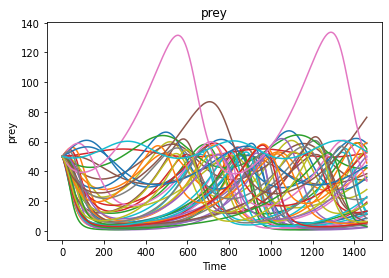

In [36]:
figure = lines(excel_results, excel_outcomes2) #show lines, and end state density
plt.show() #show figure

In [ ]:
# Multiple threats cannot access the same workbook it seems, so the MultiprocessingEvaluator will not work.
# with MultiprocessingEvaluator(excel_model) as evaluator:
#     excel_results = evaluator.perform_experiments(scenarios=50, reporting_interval=1)

### Netlogo

In [37]:
netlogo_model = NetLogoModel(name="Netlogo", wd=r'../model/', model_file=r'../model/PredPrey.nlogo')
netlogo_model.run_length = 365
netlogo_model.replications = 1
    
netlogo_model.uncertainties = uncertainties
netlogo_model.constants = constants2
netlogo_model.outcomes = outcomes

In [38]:
with MultiprocessingEvaluator(netlogo_model, n_processes=processes) as evaluator:
    netlogo_results, netlogo_outcomes = evaluator.perform_experiments(scenarios=50)

(50, 1, 366)


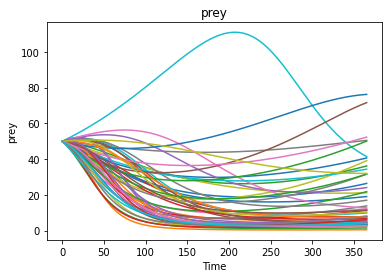

In [40]:
#This one has a different shape than the others so the function I made does not work... so manual labour it is
temp_array =  netlogo_outcomes['prey']
print(temp_array.shape)
new_a = np.reshape(temp_array, (50, 366))
netlogo_outcomes2 = {'prey': new_a}

figure = lines(netlogo_results, netlogo_outcomes2) #show lines, and end state density
plt.show() #show figure